In [1]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LeakyReLU
from tensorflow.keras.optimizers import Nadam, SGD
import matplotlib.pyplot as plt
tensorflow.compat.v1.disable_eager_execution()

# Read in data, scale, and split
The input and output training data is pre-shuffled.
* Read it in
* Generate min-max scaling numbers for each variable for input and output separately
* Scale inputs and outputs to $x \in [0,1]$
* Split it into training and testing datasets

In [2]:
path = f'supercell_kessler_data.npz'
data_link = "https://www.dropbox.com/s/6rh5at6lic377ax/supercell_kessler_data.npz?dl=0"

# Download the data if necessary
if ( not os.path.isfile(path) ):
    print(f"Downloading data from:\n {data_link}...")
    !wget {data_link} -O {path}

# Read pre-shuffled inputs and outputs
npzfile = np.load(path)
input_from_file  = npzfile['input_from_file']
output_from_file = npzfile['output_from_file']

# Total number of sampes in the file
total_samples = input_from_file.shape[0]

# Number of samples I want to use for training in this notebook
num_samples = total_samples

#Get dimension sizes
num_vars_in  = input_from_file .shape[1]
num_vars_out = output_from_file.shape[1]
num_stencil  = input_from_file .shape[2]

# This is a single-cell (non-stencil) Neural Network (NN) modeling approach
# The zeroth stencil index is the cell being predicted
# Load inputs and outputs from file
input  = np.copy(input_from_file [:num_samples,:,0])
output = np.copy(output_from_file[:num_samples,:  ])

# Get dimensions sizes
print('Getting shapes')
print(f'Input shape = {input.shape}')
print(f'Output shape = {output.shape}')
print(f'Total number of data points = {num_samples}')

# Split the dataset into testing and training portions
test_split = 0.2   # 20% of the data will never be trained on (for testing)
num_train_samples = int((1-test_split)*num_samples)
num_test_samples  = num_samples-num_train_samples

print('Scaling the input and output data and saving the scaling parameters')

sclrArrayIn  = np.ndarray(shape=[num_vars_in ,2],dtype=np.single)
sclrArrayOut = np.ndarray(shape=[num_vars_out,2],dtype=np.single)

for ivar in range(num_vars_in) :
  sclrArrayIn [ivar,0] = np.amin(input [:num_train_samples,ivar])
  sclrArrayIn [ivar,1] = np.amax(input [:num_train_samples,ivar])
for ivar in range(num_vars_out) :
  sclrArrayOut[ivar,0] = np.amin(output[:num_train_samples,ivar])
  sclrArrayOut[ivar,1] = np.amax(output[:num_train_samples,ivar])

np.savetxt('supercell_kessler_stencil_input_scaling.txt' , sclrArrayIn , fmt="%s")
np.savetxt('supercell_kessler_stencil_output_scaling.txt', sclrArrayOut, fmt="%s")

for ivar in range(num_vars_in) :
  input [:,ivar] = (input [:,ivar] - sclrArrayIn [ivar,0]) / (sclrArrayIn [ivar,1] - sclrArrayIn [ivar,0])
for ivar in range(num_vars_out) :
  output[:,ivar] = (output[:,ivar] - sclrArrayOut[ivar,0]) / (sclrArrayOut[ivar,1] - sclrArrayOut[ivar,0])

print('Splitting the dataset into training and testing portions')

# Training data
input_train  = input [:num_train_samples, :]
output_train = output[:num_train_samples, :]
# Testing data
input_test   = input [num_train_samples:, :]
output_test  = output[num_train_samples:, :]


Getting shapes
Input shape = (9118906, 5)
Output shape = (9118906, 4)
Total number of data points = 9118906
Scaling the input and output data and saving the scaling parameters
Splitting the dataset into training and testing portions


# Create and train Neural Network

In [11]:
# Create the Keras Neural Network
model = Sequential()
model.add( Dense(10,input_dim=num_vars_in,kernel_initializer="RandomUniform") )
model.add( LeakyReLU(alpha=0.1) )
model.add( Dense(num_vars_out,kernel_initializer="RandomUniform") )
model.compile(loss='mse', optimizer=Nadam(), metrics=['mean_absolute_error'])
print(model.summary())

history = model.fit(input_train, output_train, epochs=10, batch_size=1024, validation_split=0.2, verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                60        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 10)                0         
                                                                 
 dense_7 (Dense)             (None, 4)                 44        
                                                                 
Total params: 104
Trainable params: 104
Non-trainable params: 0
_________________________________________________________________
None
Train on 5836099 samples, validate on 1459025 samples
Epoch 1/10
5818368/5836099 [============================>.] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0118

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


5836099/5836099 [==============================] - 11s 2us/sample - loss: 0.0019 - mean_absolute_error: 0.0118 - val_loss: 1.0106e-06 - val_mean_absolute_error: 6.8069e-04
Epoch 2/10
5836099/5836099 [==============================] - 11s 2us/sample - loss: 5.1380e-07 - mean_absolute_error: 4.7019e-04 - val_loss: 4.0657e-08 - val_mean_absolute_error: 9.7591e-05
Epoch 3/10
5836099/5836099 [==============================] - 11s 2us/sample - loss: 2.3539e-07 - mean_absolute_error: 3.3241e-04 - val_loss: 1.0705e-07 - val_mean_absolute_error: 2.5120e-04
Epoch 4/10
5836099/5836099 [==============================] - 11s 2us/sample - loss: 1.8381e-07 - mean_absolute_error: 2.9256e-04 - val_loss: 3.0436e-07 - val_mean_absolute_error: 4.2042e-04
Epoch 5/10
5836099/5836099 [==============================] - 11s 2us/sample - loss: 1.6546e-07 - mean_absolute_error: 2.7562e-04 - val_loss: 1.2840e-06 - val_mean_absolute_error: 9.2028e-04
Epoch 6/10
5836099/5836099 [==============================] - 11

# Inference traine NN on test data

In [4]:
predict_test = model.predict( input_test )

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


# Compare test predictions to test output

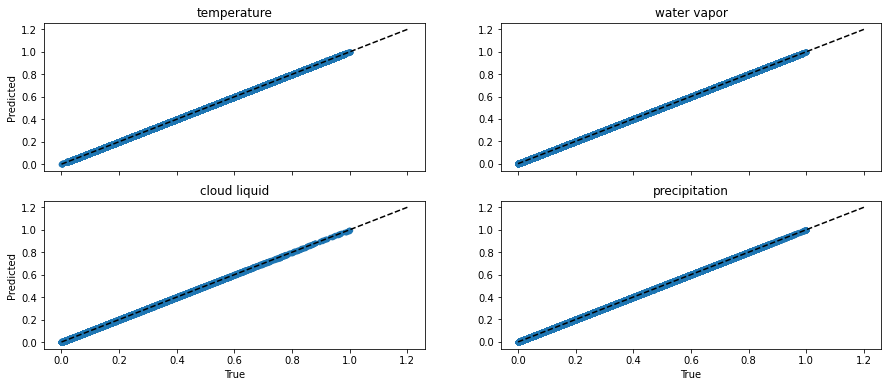

In [5]:
titlestr = np.array(['temperature','water vapor','cloud liquid','precipitation'])

fig, axs = plt.subplots(2,2,figsize=(15,6),sharex=True,facecolor="1")
axs = axs.ravel()
for i in range(4):
    axs[i].scatter(output_test[:,i],predict_test[:,i],s=20)
    axs[i].plot(np.linspace(0,1.2),np.linspace(0,1.2),'--',color='k')
    axs[i].set_title(r''+titlestr[i])
axs[2].set_xlabel(r'True'); axs[3].set_xlabel(r'True');
axs[0].set_ylabel(r'Predicted'); axs[2].set_ylabel(r'Predicted');

In [6]:
print( 'Maximum relative test errors: ' , np.amax(np.abs(output_test-predict_test),axis=0) / np.amax(np.abs(output_test),axis=0) )
print( 'Mean relative test errors:    ' , np.mean(np.abs(output_test-predict_test),axis=0) / np.mean(np.abs(output_test),axis=0) )
print( 'Mean relative test bias:      ' , np.mean(output_test-predict_test,axis=0) / np.mean(np.abs(output_test),axis=0) )

Maximum relative test errors:  [0.00755035 0.00543387 0.00566697 0.00428575]
Mean relative test errors:     [6.5660111e-05 2.3050897e-03 1.3457319e-02 3.2070293e-03]
Mean relative test bias:       [ 4.8737653e-05  2.3015041e-03  1.2084821e-02 -2.0276136e-03]


# Save the model weights

In [7]:
# For inference: Serialize model to JSON
model_json = model.to_json()
with open('supercell_kessler_singlecell_model_weights.json', 'w') as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights('supercell_kessler_singlecell_model_weights.h5')
print('Saved model to disk')

Saved model to disk


# Create integer array for active samples: binary 0 or 1

In [8]:
tol = 0.000000
active = np.where((np.abs(output_from_file[:,0] - input_from_file[:,0,0]) > 0) | \
                  (np.abs(output_from_file[:,1] - input_from_file[:,2,0]) > 0) | \
                  (np.abs(output_from_file[:,2] - input_from_file[:,3,0]) > 0) | \
                  (np.abs(output_from_file[:,3] - input_from_file[:,4,0]) > 0) , True , False )
active_train = np.copy(active[:num_train_samples])
active_test  = np.copy(active[num_train_samples:])
print( "Percentage of total samples that are active: " , np.sum(active) / num_samples*100 , "%" )
print( "Percentage of training samples that are active: " , np.sum(active_train) / num_train_samples*100 , "%" )
print( "Percentage of test samples that are active: " , np.sum(active_test) / num_test_samples*100 , "%" )

Percentage of total samples that are active:  51.812487155805755 %
Percentage of training samples that are active:  51.8007507480339 %
Percentage of test samples that are active:  51.85943276115238 %


# Train a binary classification Neural Network to determine if a cell is active

In [9]:
# Create the Keras Neural Network
model = Sequential()
model.add( Dense(10,input_dim=num_vars_in,kernel_initializer="RandomUniform") )
model.add( LeakyReLU(alpha=0.1) )
model.add( Dense(1,kernel_initializer="RandomUniform",activation="sigmoid") )
model.compile(optimizer=Nadam(), loss='binary_crossentropy',metrics =['accuracy'])
print(model.summary())

history = model.fit(input_train, active_train, epochs=10, batch_size=1024, validation_split=0.2, verbose=1)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                60        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________
None
Train on 5836099 samples, validate on 1459025 samples
Epoch 1/10
5817344/5836099 [============================>.] - ETA: 0s - loss: 0.4412 - accuracy: 0.7657

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


5836099/5836099 [==============================] - 11s 2us/sample - loss: 0.4410 - accuracy: 0.7657 - val_loss: 0.3813 - val_accuracy: 0.7913
Epoch 2/10
5836099/5836099 [==============================] - 11s 2us/sample - loss: 0.3657 - accuracy: 0.7985 - val_loss: 0.3531 - val_accuracy: 0.8056
Epoch 3/10
5836099/5836099 [==============================] - 11s 2us/sample - loss: 0.3462 - accuracy: 0.8094 - val_loss: 0.3389 - val_accuracy: 0.8136
Epoch 4/10
5836099/5836099 [==============================] - 11s 2us/sample - loss: 0.3331 - accuracy: 0.8191 - val_loss: 0.3262 - val_accuracy: 0.8286
Epoch 5/10
5836099/5836099 [==============================] - 11s 2us/sample - loss: 0.3219 - accuracy: 0.8317 - val_loss: 0.3168 - val_accuracy: 0.8393
Epoch 6/10
5836099/5836099 [==============================] - 11s 2us/sample - loss: 0.3136 - accuracy: 0.8448 - val_loss: 0.3093 - val_accuracy: 0.8522
Epoch 7/10
5836099/5836099 [==============================] - 11s 2us/sample - loss: 0.3070 -